In [85]:
import pytesseract
import easyocr
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [86]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow', 'models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace', 'annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace', 'images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace', 'pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME),
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'export'),
    'TFJS_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfjsexport'),
    'TFLITE_PATH': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'tfliteexport'),
    'PROTOC_PATH': os.path.join('Tensorflow', 'protoc')
}

files = {
    'PIPELINE_CONFIG': os.path.join('Tensorflow', 'workspace', 'models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}


In [87]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(
    model_config=configs['model'],
    is_training=False
    )

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(
    paths['CHECKPOINT_PATH'],
    'ckpt-11')).expect_partial()


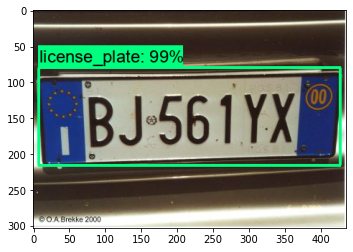

In [105]:
def detect_plate(image):
    '''function for detecting the plate using trained model'''
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'number_plates', '11.jpg')

# Detect license plate from images
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
try:
    detections = detect_plate(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(
        np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=.2,
        agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

except ValueError:
    print("Image not found!")


# Image Pre Processing

In [106]:
def ocr_image_preprocessing(image):
    '''function for pre-processing the image for ocr'''
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur_image = cv2.medianBlur(gray_image, 5)
    thresh_image = cv2.threshold(blur_image, 0, 227, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    plt.imshow(cv2.cvtColor(thresh_image, cv2.COLOR_BGR2RGB))
    plt.show()
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(thresh_image, detail=0)
    print(ocr_result)

    return image

# Finding ROI and Contours

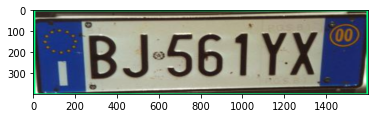

2

In [107]:
detection_threshold = 0.2
image = image_np_with_detections
scores = list(filter(lambda x: x >= detection_threshold,detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

width = image.shape[1]
height = image.shape[0]

# Apply ROI filtering
for idx, box in enumerate(boxes):
    roi = box*[height, width, height, width]
    region = image[int(roi[0]):int(roi[2]), int(roi[1]):int(roi[3])]
    resize_width = 1600
    resize_height = 400
    region = cv2.resize(region, (resize_width, resize_height))
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    plt.show()

kernel = np.ones((7, 7), np.uint8)
hsv = cv2.cvtColor(region, cv2.COLOR_BGR2HSV)

# lower bound and upper bound for Yellow color
lower_bound = np.array([90, 50, 70])
upper_bound = np.array([128, 255, 255])

mask = cv2.inRange(hsv, lower_bound, upper_bound)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
segmented_image = cv2.bitwise_and(region, region, mask=mask)

contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = cv2.drawContours(region, contours, -1, (0, 0, 255), 3)
len(contours)

# Text Extraction Using OCR

Contour


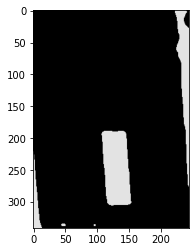

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]


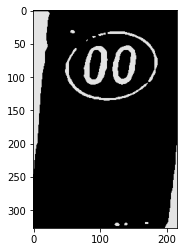

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['(00']


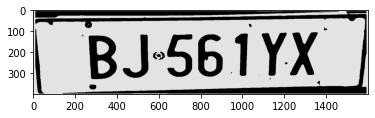

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['BJ-561YX']


In [108]:
if len(contours) < 4:
    print("Contour")
    i = 0
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        crop_image = output[y:y+h, x:x+w]
        ocr_image_preprocessing(crop_image)
        i += 1

    result = cv2.drawContours(region, contours, contourIdx=-1, color=(255, 255, 255), thickness=-1)
    ocr_image_preprocessing(result)

else:
    print("Coordinates")
    middle_portion = region[0:resize_height, 160:resize_width-160]
    ocr_image_preprocessing(middle_portion)

    left_portion = region[0:resize_height, 0:160]
    ocr_image_preprocessing(left_portion)

    right_portion = region[0:resize_height, resize_width-160:resize_width]
    ocr_image_preprocessing(right_portion)